### Segmentação de Clientes

> Neste trabalho, usaremos o banco de dados da Olist com K-means para identificar a frequência, recência e receita dos consumidores e agrupa-los em categorias de compras. Assim podemos fazer campanhas de marketing específicas, além de criar programas de recompensas para os clientes que mais consomem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df=pd.read_csv('BancoDeDados.csv')

In [3]:
df.shape

(116581, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amostra               116581 non-null  int64  
 1   id_cliente            116581 non-null  object 
 2   id_unico_cliente      116581 non-null  object 
 3   item_id               116581 non-null  int64  
 4   cep_cliente           116581 non-null  int64  
 5   cidade_cliente        116581 non-null  object 
 6   estado_cliente        116581 non-null  object 
 7   id_pedido             116581 non-null  object 
 8   status_pedido         116581 non-null  object 
 9   horario_pedido        116581 non-null  object 
 10  pedido_aprovado       116567 non-null  object 
 11  pedido_entregador     115368 non-null  object 
 12  pedido_entregue       114066 non-null  object 
 13  data_estimada         116581 non-null  object 
 14  id_vendedor           116581 non-null  object 
 15  

In [5]:
df.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,pedido_aprovado,pedido_entregador,pedido_entregue,data_estimada,id_vendedor,preco,frete,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,7c67e1448b00f6e969d365cea6b010ab,112.99,24.90,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,7c67e1448b00f6e969d365cea6b010ab,112.99,24.90,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,7c67e1448b00f6e969d365cea6b010ab,124.99,15.62,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,7c67e1448b00f6e969d365cea6b010ab,106.99,30.59,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


### Análise Exploratória

In [6]:
def plot_perc(st,dados):
    plt.figure(figsize=(20,8))

    g = sns.countplot(x=st, data=dados, orient='h')
    g.set_title("Distribuição do estado dos clientes", fontsize=20)
    g.set_xlabel("Estado", fontsize=17)
    g.set_ylabel("Contagem", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/1.6,
            height + 200,
            '{:1.2f}%'.format(height/26634*100),
            ha="center", va='bottom',fontsize=12) 
    g.set_ylim(0, max(sizes) * 1.1)

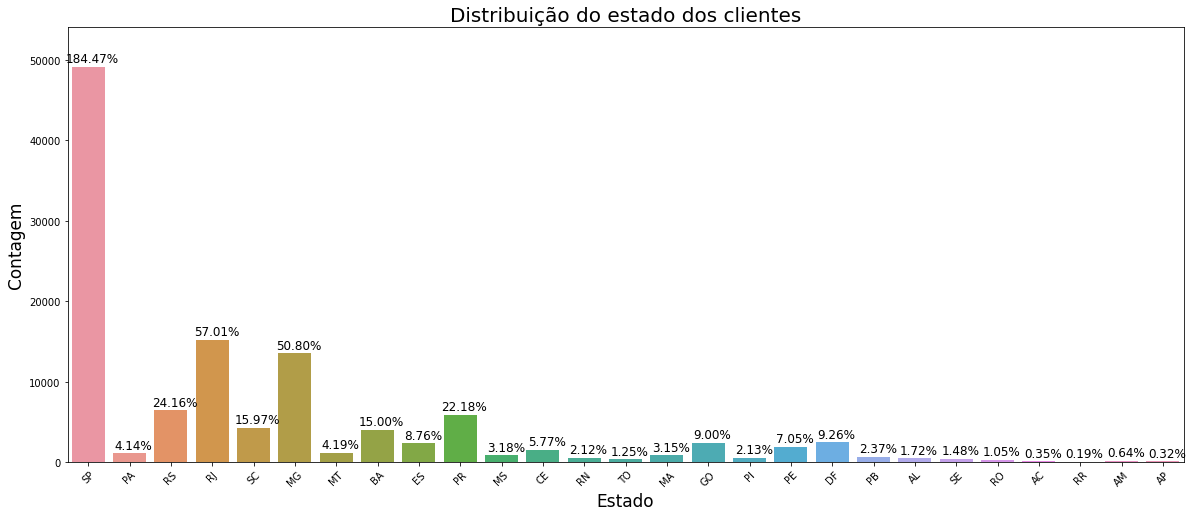

In [7]:
plot_perc('estado_cliente',df)

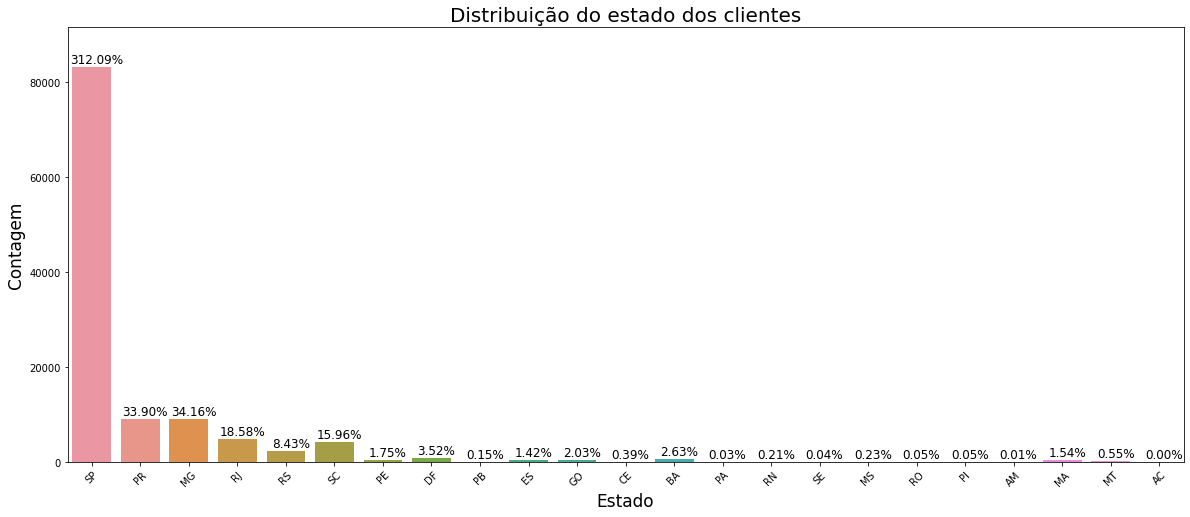

In [8]:
plot_perc('estado_vendedor',df)

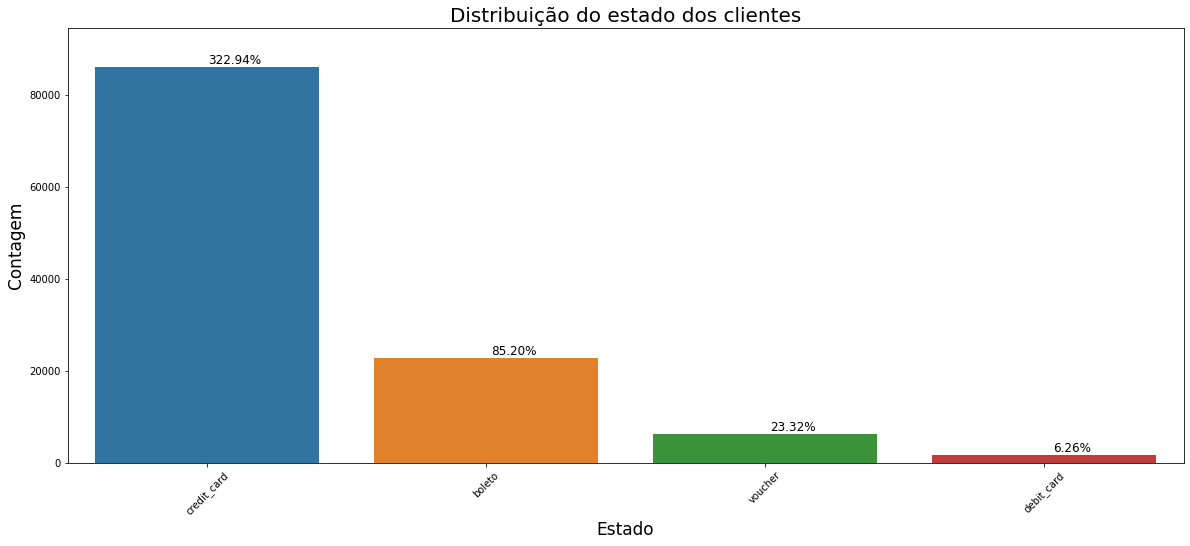

In [9]:
plot_perc('pagamento_tipo',df)

- Identificamos primeiramente que a maioria dos clientes realiza compras por cartão de crédito, posteriormente por boleto, voucher e cartão de débito. Seria interessante aumentar as promoções para pagamento à vista (para aumento dos pagamentos com boleto ou cartão de débito).
- Também percebe-se que a maioria dos vendedores e compradores estão em SP.

> Agora que temos um banco de dados completo, podemos salva-lo para utilizar posteriormente. Também vou criar um novo banco de dados apenas com as informações que vou precisar para fazer a análise de recẽncia, frequência e receita.

**Recência**: Há quantos dias foi a ultima compra desse cliente?

**Frequencia**: Quantas compras esse cliente já fez na sua empresa, desde que se cadastrou?

**Monetaridade**: Quanto esse cliente já gastou em dinheiro na sua empresa?

In [10]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']]

In [11]:
df_compra = df.groupby('id_unico_cliente').horario_pedido.max().reset_index()
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra']

In [12]:
df_compra['DataMaxCompra']= pd.to_datetime(df_compra['DataMaxCompra']) 

> Precisamos definir agora as três variáveis que utilizaremos para segmentação: **recência**, **frequência** e **receita**. Em inglês, é chamado de método RFM. Este é um método utilizado para analisar o comportamento do cliente e definir segmentos de mercado. :

> - Recência: quão recentemente um cliente fez uma compra. É um importante preditor, pois um cliente que comprou há pouco tempo tem mais chance de voltar a comprar do que aquele que comprou há muito tempo, além de apresentar uma probabilidade maior de responder a promoções.
- Frequência: com que frequência um cliente faz uma compra.  Se um cliente compra frequentemente, espera-se que ele volte a comprar.
- Receita: quanto dinheiro um cliente gasta em compras. Aqueles clientes que gastaram muito têm mais valor para a organização em comparação com aqueles que gastaram menos

In [13]:
#seleciona o ponto de observação como a data máxima de compra em nosso df
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days
df_compra.head()

,id_unico_cliente,DataMaxCompra,Recencia
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


In [14]:
#junta esse df com o nosso novo chamado df_user
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente','Recencia']], on='id_unico_cliente')

df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211


In [15]:
def calcular_wcss(data): # inercia
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=data)
        data["clusters"] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

> Agora precisamos usar o Método Cotovelo, a ideia é rodar o KMeans para várias quantidades diferentes de clusters e dizer qual dessas quantidades é o número ótimo de clusters. Usando a "regra do cotovelo", identificamos que a partir de 4 clusters teremos bons resultados. Vou usar 5 apenas para garantir.

> O que geralmente acontece ao aumentar a quantidade de clusters no KMeans é que as diferenças entre clusters se tornam muito pequenas, e as diferenças das observações intra-clusters vão aumentando. Então é preciso achar um equilíbrio em que as observações que formam cada agrupamento sejam o mais homogêneas possível e que os agrupamentos formados sejam o mais diferentes um dos outros.

In [16]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.cluster import KMeans

In [17]:
df_recencia = df_usuario[['Recencia']]
df_recencia.head()

,Recencia
0,474
1,298
2,298
3,483
4,211


In [18]:
soma_quadrados = calcular_wcss(df_recencia) # inercia
soma_quadrados

[2733029504.9432926,
 807902990.2834922,
 362034954.49866176,
 213824487.56023872,
 135961910.81493264,
 96353641.79308766,
 69833749.19839448,
 55739044.62309228,
 44181826.49752256]

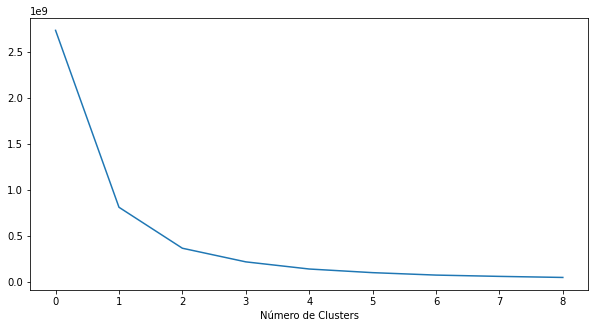

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(soma_quadrados)
plt.xlabel("Número de Clusters")
plt.show()

> Mas como podemos identificar se o melhor número de clusters é 3, 4 ou 5? Existe uma solução matemática! Primeiramente, definimos uma reta ligando o primeiro ponto (cluster 1) ao último ponto (cluster 9). Então, calculamos a distância de cada ponto até a reta usando a seguinte equação:

![](https://miro.medium.com/max/2775/1*9J7Wnh5L0eIcHXBeWlzvNA.png)

> Neste caso, P0 é o ponto do cluster 1 e P1 o ponto do cluster 9. O par (x,y) representa as coordenadas de qualquer ponto que a gente queira calcular a distância. Calculando todas as distância, conseguimos determinar o ponto ideal!

In [20]:
import math
def numero_otimo_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distancias = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerador = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancias.append(numerador/denominador)
    
    return distancias.index(max(distancias)) + 2

In [21]:
# calculando a soma dos quadrados para as quantidade de clusters
soma_quadrados = calcular_wcss(df_recencia)

# calculando a quantidade ótima de clusters
n = numero_otimo_clusters(soma_quadrados)

> E agora o número ideal de clusters!

In [22]:
n

4

In [23]:
# rodando o kmeans para nossa quantidade ótima de clusters
kmeans = KMeans(n_clusters=4)
df_usuario['RecenciaCluster'] = kmeans.fit_predict(df_recencia)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,1
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298,2
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298,2
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,1
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211,0


In [24]:
agrupado_por_cluster = df_usuario.groupby('RecenciaCluster')['Recencia'].mean().reset_index()
agrupado_por_cluster.head()

,RecenciaCluster,Recencia
0,0,187.076277
1,1,489.070832
2,2,318.687376
3,3,66.405850


In [25]:
agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by = 'Recencia', ascending = False).reset_index(drop = True)
agrupado_por_cluster_ordenado.head()

,RecenciaCluster,Recencia
0,1,489.070832
1,2,318.687376
2,0,187.076277
3,3,66.405850


In [26]:
agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
agrupado_por_cluster_ordenado.head()

,RecenciaCluster,Recencia,index
0,1,489.070832,0
1,2,318.687376,1
2,0,187.076277,2
3,3,66.405850,3


In [27]:
juntando_cluster = pd.merge(df_usuario, agrupado_por_cluster_ordenado[['RecenciaCluster','index']], on = 'RecenciaCluster')
juntando_cluster.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,1,0


In [28]:
removendo_dados = juntando_cluster.drop(['RecenciaCluster'], axis = 1)
removendo_dados.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,index
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [29]:
df_final = removendo_dados.rename(columns = {'index': 'RecenciaCluster'})
df_final.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [30]:
#função para ordenar o número de clusters 
def ordenar_cluster(cluster_nome, target_nome,df,ascending):
    novo_nome = 'novo' + cluster_nome
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                     ascending=ascending).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns={"index":cluster_nome})
    return df_final

df_usuario = ordenar_cluster('RecenciaCluster', 'Recencia',df_usuario,False)

In [31]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [32]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,20697.0,489.070832,59.862148,404.0,441.0,480.0,532.0,728.0
1,30695.0,318.687376,43.450070,253.0,281.0,312.0,355.0,403.0
2,33601.0,187.076277,35.024122,127.0,157.0,187.0,217.0,252.0
3,31588.0,66.405850,35.800016,0.0,33.0,67.0,99.0,126.0


In [33]:
# cria um df com a quantidade de ordens para cada cliente
df_frequencia = df.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente','Frequencia']

df_frequencia.head()

,id_unico_cliente,Frequencia
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [34]:
# adiciona esses dados em nosso df principal
df_usuario = pd.merge(df_usuario, df_frequencia, on='id_unico_cliente')

In [35]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1


In [36]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_frequencia = df_usuario[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)

In [37]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0


In [38]:
# ordena os clusters de frequência
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,731.0,21.489740,6.588977,14.0,15.0,21.0,24.0,38.0
2,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0
3,9205.0,5.644432,2.138491,4.0,4.0,5.0,6.0,13.0


In [39]:
df_usuario = ordenar_cluster('FrequenciaCluster', 'Frequencia',df_usuario,True)

In [40]:
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,9205.0,5.644432,2.138491,4.0,4.0,5.0,6.0,13.0
2,731.0,21.489740,6.588977,14.0,15.0,21.0,24.0,38.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


In [41]:
#calcula a receita para cada cliente
df_receita = df.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()
df_receita.columns = ['id_unico_cliente', 'Receita']
df_receita.head()

,id_unico_cliente,Receita
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [42]:
#junta com o df principal
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33


In [43]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_pagamento = df_usuario[['Receita']]
kmeans = KMeans(n_clusters=4)
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)

In [44]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33,0


In [45]:
df_usuario = ordenar_cluster('ReceitaCluster', 'Receita', df_usuario, True)

In [46]:
#ordena os clusters
df_usuario.groupby('ReceitaCluster')['Receita'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114798.0,258.918361,367.870074,9.59,69.90,132.60,269.28,2971.85
1,1584.0,5709.531187,2885.449918,2987.84,3610.00,4564.75,7006.19,16313.60
2,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


In [47]:
df_final = df_usuario.drop(['id_cliente','horario_pedido','item_id','preco'],axis=1)
df_final.head()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0


In [48]:
#renomeando as colunas
df_final.columns = ['Id_unico_cliente', 'Recencia', 'RecenciaCluster', 'Frequencia', 'FrequenciaCluster', 'Receita', 'ReceitaCluster']

In [49]:
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0


> Calcularemos a pontuação geral do cliente baseado nesses clusters e também definimos 4 opções: inativo, business, master e premium. 

In [50]:
df_final['Pontuacao'] = df_usuario['RecenciaCluster'] + df_usuario['FrequenciaCluster'] + df_usuario['ReceitaCluster']
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0


In [51]:
df_final.Pontuacao.max()

7

In [52]:
df_final['Segmento'] = 'Inativo'

In [61]:
df_final.loc[df_final['Pontuacao']>=1,'Segmento'] = 'Business' 
df_final.loc[df_final['Pontuacao']>=3,'Segmento'] = 'Master' 
df_final.loc[df_final['Pontuacao']>=5,'Segmento'] = 'Premium' 

In [62]:
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao,Segmento
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0,Inativo
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0,Inativo
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0,Inativo
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0,Inativo
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0,Inativo


In [63]:
df_final.to_csv('RFM.csv')

In [64]:
def plot_segmento(x,y,data):
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, axs = plt.subplots(1, 1, figsize=(7, 5))
    sns.despine(left=True)
    sns.scatterplot(x=x, y=y, hue='Segmento', data=data, size='Segmento', sizes=(50,150), size_order=['Premium','Master','Business','Inativo'])
    axs.set_title('Segmento de Cliente')
    plt.show()

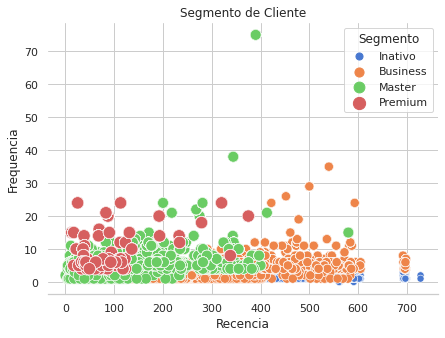

In [65]:
plot_segmento('Recencia','Frequencia',df_final)

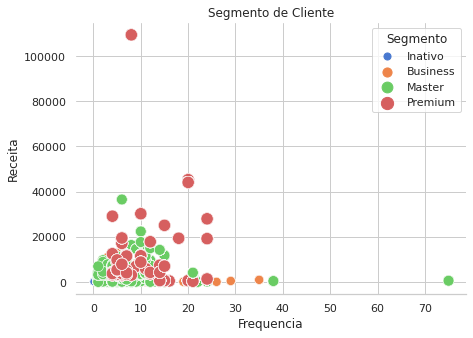

In [66]:
plot_segmento('Frequencia','Receita',df_final)

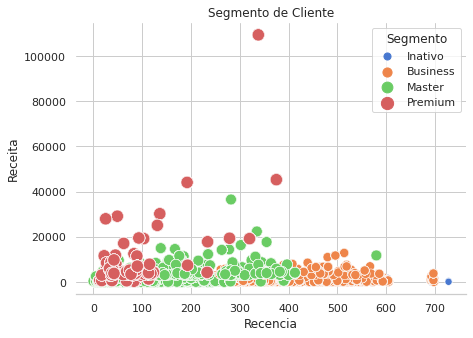

In [67]:
plot_segmento('Recencia','Receita',df_final)

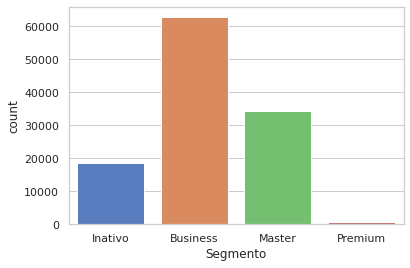

In [68]:
sns.countplot(df_final['Segmento'])

| **Segmentos**        | **Descrição**                                                      | **Recência** | **Frequência** | **Receita** |
|----------------------|--------------------------------------------------------------------|--------------|----------------|-------------|
| Campeões             | Compraram recentemente, compram com frequência e gastam muito      | 4-5          | 4-5            | 4-5         |
| Clientes fiéis       | Gastam muito e respondem a promoções                               | 2-5          | 3-5            | 3-5         |
| Potencialmente fiéis | Compraram recentemente, mais de uma vez e gastaram uma boa quantia | 3-5          | 1-3            | 1-3         |
| Novos clientes       | Compraram recentemente, mas não compram com frequência             | 4-5          | <=1            | <=1         |
| Promissores          | Compraram recentemente, mas não gastaram muito                     | 3-4          | <=1            | <=1         |
| Precisam de atenção  | Recência, frequência e valor monetário acima da média              | 2-3          | 2-3            | 2-3         |
| Quase em risco       | Recência, frequência e valor monetário abaixo da média             | 2-3          | <=2            | <=2         |
| De risco             | Gastaram muito, compraram muitas vezes, mas há muito tempo         | <=2          | 2-5            | 2-5         |
| Não pode perdê-los   | Compraram muito e com frequência, mas há muito tempo               | <=1          | 4-5            | 4-5         |
| Hibernando           | Compraram pouco, com baixa frequência e há muito tempo             | 1-2          | 1-2            | 1-2         |
| Perdidos             | Recência, frequência e valores monetários baixos                   | <=2          | <=2            | <=2         |

In [69]:
df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Campeao'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Fiel'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] = 'Potencialmente Fiel - Tipo 1'

df_final.loc[(df_final['RecenciaCluster']==1) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==3),'Segmento'] = 'Potencialmente Fiel - Tipo 2'

df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==0) & (df_final['ReceitaCluster']==0),'Segmento'] = 'Novos'

df_final.loc[(df_final['RecenciaCluster']==0) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] = 'Promissores'

df_final.loc[(df_final['RecenciaCluster']==2) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] = 'Precisam Atencao'

df_final.loc[(df_final['RecenciaCluster']==2) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] ='Quase em Risco'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==2) & (df_final['ReceitaCluster']==2),'Segmento'] ='Risco'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==3) & (df_final['ReceitaCluster']==3),'Segmento'] ='Nao pode perder - Tipo 1'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==1) & (df_final['ReceitaCluster']==1),'Segmento'] ='Hibernando'

df_final.loc[(df_final['RecenciaCluster']==3) & (df_final['FrequenciaCluster']==0) & (df_final['ReceitaCluster']==0),'Segmento'] ='Perdidos'

In [75]:
def agrupar(p,q,r,segmento):
    df_final.loc[(df_final['RecenciaCluster']==p) & (df_final['FrequenciaCluster']==q) & (df_final['ReceitaCluster']==r),'Segmento'] ='segmento'

In [78]:
agrupar(3,0,0,'Perdidos')


In [80]:
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao,Segmento
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0,0,Novos
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0,0,Novos
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0,0,Novos
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0,0,Novos
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0,0,Novos


# Conclusão

<h1>Segmentação</h1>

***
Realizada pelo modelo RFM:
* Recencia: Há quantos dias foi a ultima compra desse cliente?
* Frequencia: Quantas compras esse cliente já fez na sua empresa, desde que se cadastrou?
* Monetaridade/receita: Quanto esse cliente já gastou em dinheiro na sua empresa?

***

* Utilizando k-means
* 4 clusters por conjunto RFM
    * Regra do cotovelo
    * Regra matemática
* Pontuação (score): O numero de cluster se transformou em pontuação a qual foi somado para chegar no score final de cada cliente
* Criação de segmentos
    * Master
    * Business
    * Inativo
    * Premium

* Dentro do banco de dados
    * 15% dos clientes são inativos
    * 53,84% estão dentro da categoria Business
    * 26,66% estão dentro da categoria Master
    * 0,60% estão dentro da categoria Premium
***
**Ações a serem tomadas**
*** 
* Recuperar os inativos (Promoções e cupons especiais)
* Fornecer descontos especiais de frete aos 'Master'
* Descontos especiais aos 'Premium' e atendimento especializado.